In [1]:
import pandas as pd
import random

# Experiments
import sys
sys.path.append('../..')
from model import run
from model.plot_utils import *
from model.amm.basilisk_amm import ConstantProductPoolState
from model.amm.agents import Agent
from model.amm.global_state import GlobalState
from model.amm.trade_strategies import TradeStrategies
import matplotlib.pyplot as plt

from model import init_utils
from model import processing

# same seed, same parameters = same simulation result
random.seed(42)

initial_state = GlobalState(
    pools = {
        'R1/R2': ConstantProductPoolState(
            tokens={
                'R1': 1000000,
                'R2': 1000000
            },
            trade_fee=0.001,
            fee_function = ConstantProductPoolState.custom_slip_fee(0.1)
        ),
        'R2/R3': ConstantProductPoolState(
            tokens={
                'R3': 1000000,
                'R2': 1000000
            },
            trade_fee=0.001,
            fee_function = ConstantProductPoolState.custom_slip_fee(0.2)
        ),
        'R1/R3': ConstantProductPoolState(
            tokens={
                'R1': 1000000,
                'R3': 1000000
            },
            trade_fee=0.001,
            fee_function = ConstantProductPoolState.thorchain_fee
        ),
    },

    agents = {
        'Trader1 (low volume)': Agent(
            holdings={'R1': 10000, 'R2': 10000},
            trade_strategy=TradeStrategies.random_swaps(pool='R1/R2', amount={'R1': 1000, 'R2': 1000}, randomize_amount=True)
        ),
        'Trader2 (mid volume)': Agent(
            holdings={'R2': 500000, 'R3': 500000},
            trade_strategy=TradeStrategies.random_swaps(pool='R2/R3', amount={'R3': 50000, 'R2': 50000}, randomize_amount=True)
        ),
        'Trader3 (high volume)': Agent(
            holdings={'R1': 1000000, 'R3': 1000000},
            trade_strategy=TradeStrategies.random_swaps(pool='R1/R3', amount={'R1': 100000, 'R3': 100000}, randomize_amount=True)
        )
    },
    
    external_market = {
        'R1': 1,
        'R2': 1
    }
)

state = {'state': initial_state}
config_dict = init_utils.get_configuration(timesteps=5000)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (5000, 1, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 2.43s


In [2]:
# rdf, agent_df = processing.postprocessing(events, optional_params=['holdings_val'])

dict_keys(['R1/R2', 'R2/R3', 'R1/R3'])


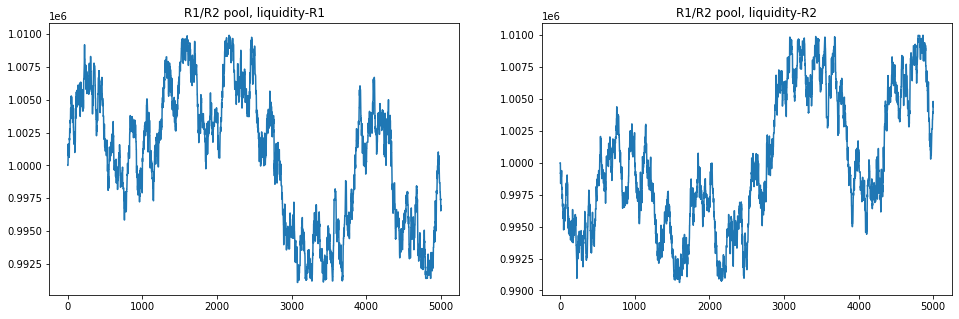

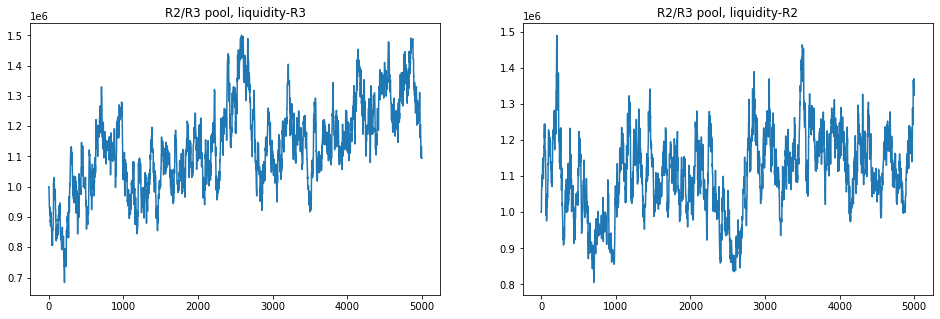

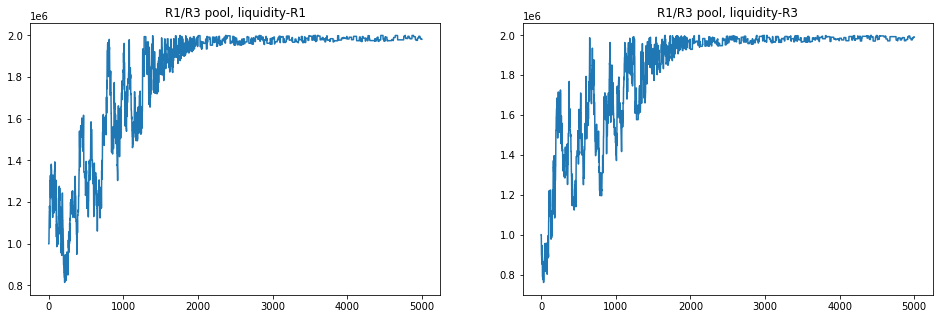

In [3]:
pools = events[0]['state'].pools
r = {poolname: 
     {asset: 
      [event['state'].pools[poolname].liquidity[asset] for event in events] 
      for asset in pool.asset_list} 
     for poolname, pool in pools.items()
    }

print (r.keys())
for pool in r:
    plt.figure(figsize=(25,5))
    for i, asset in enumerate(r[pool]):
        bounds = (1, 3, i + 1)        
        ax = plt.subplot(*bounds, title=f'{pool} pool, liquidity-{asset}')
        ax.plot(list(range(len(r[pool][asset]))), r[pool][asset])
        

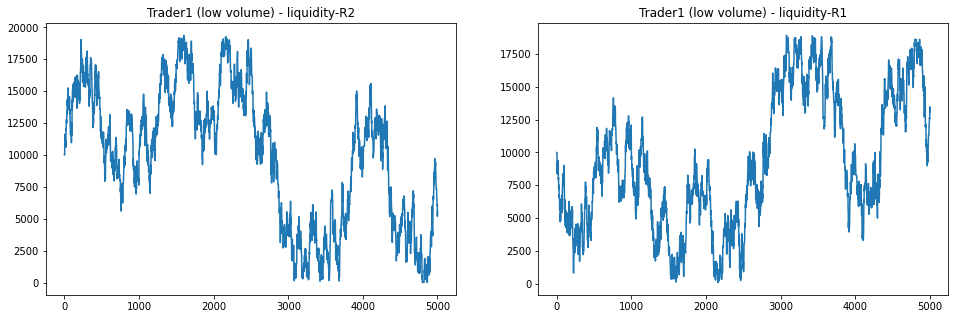

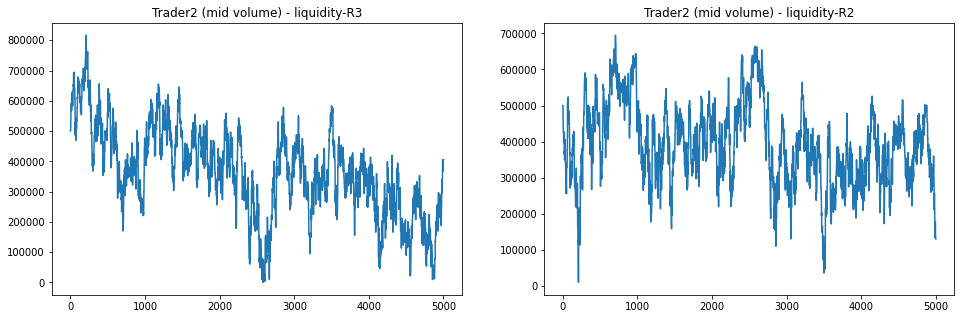

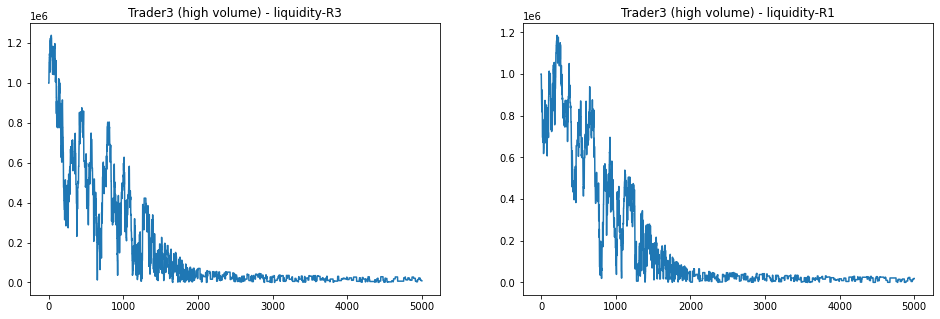

In [4]:

holdings = {agent.unique_id: 
            {asset: 
             [event['state'].agents[agent.unique_id].holdings[asset] for event in events] 
             for asset in agent.asset_list} 
            for agent in events[0]['state'].agents.values()
           }

for agent in holdings:
    plt.figure(figsize=(25,5))
    for i, asset in enumerate(holdings[agent]):
        bounds = (1, 3, i + 1)
        ax = plt.subplot(*bounds, title=f'{agent} - liquidity-{asset}')
        ax.plot(list(range(len(holdings[agent][asset]))), holdings[agent][asset])